In [7]:
import torch
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

import numpy as np

num_dim = 2 # number of different features
num_discrete_values = 8 # number of values that X can take
num_qubits = num_dim * int(np.log2(num_discrete_values))

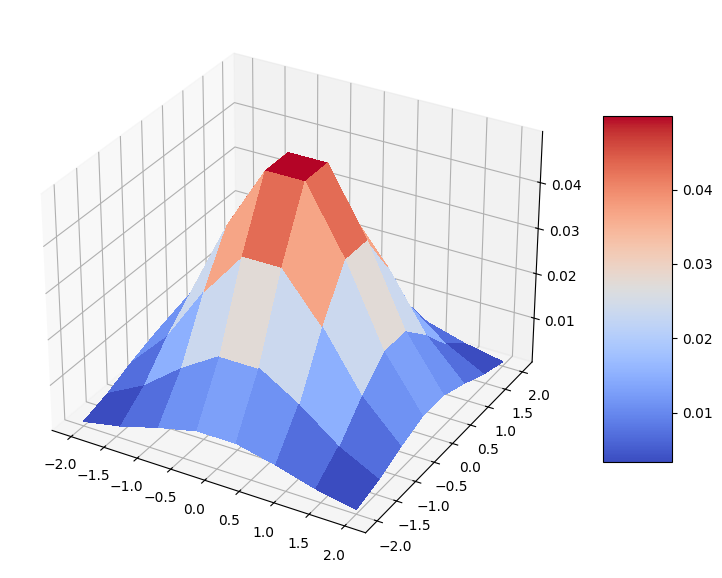

In [8]:
# set up the training data

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [9]:
from qGAN import DistributionCircuitTrainer
trainer = DistributionCircuitTrainer(num_dim, num_discrete_values)

# setup the qGAN
trainer.define_init_distribution(init_dist = "uniform")
trainer.define_generator(ansatz="efficient-su2")
trainer.define_discriminator()
trainer.define_loss()

lr = 0.001  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter
trainer.define_optimizer(lr, b1, b2)

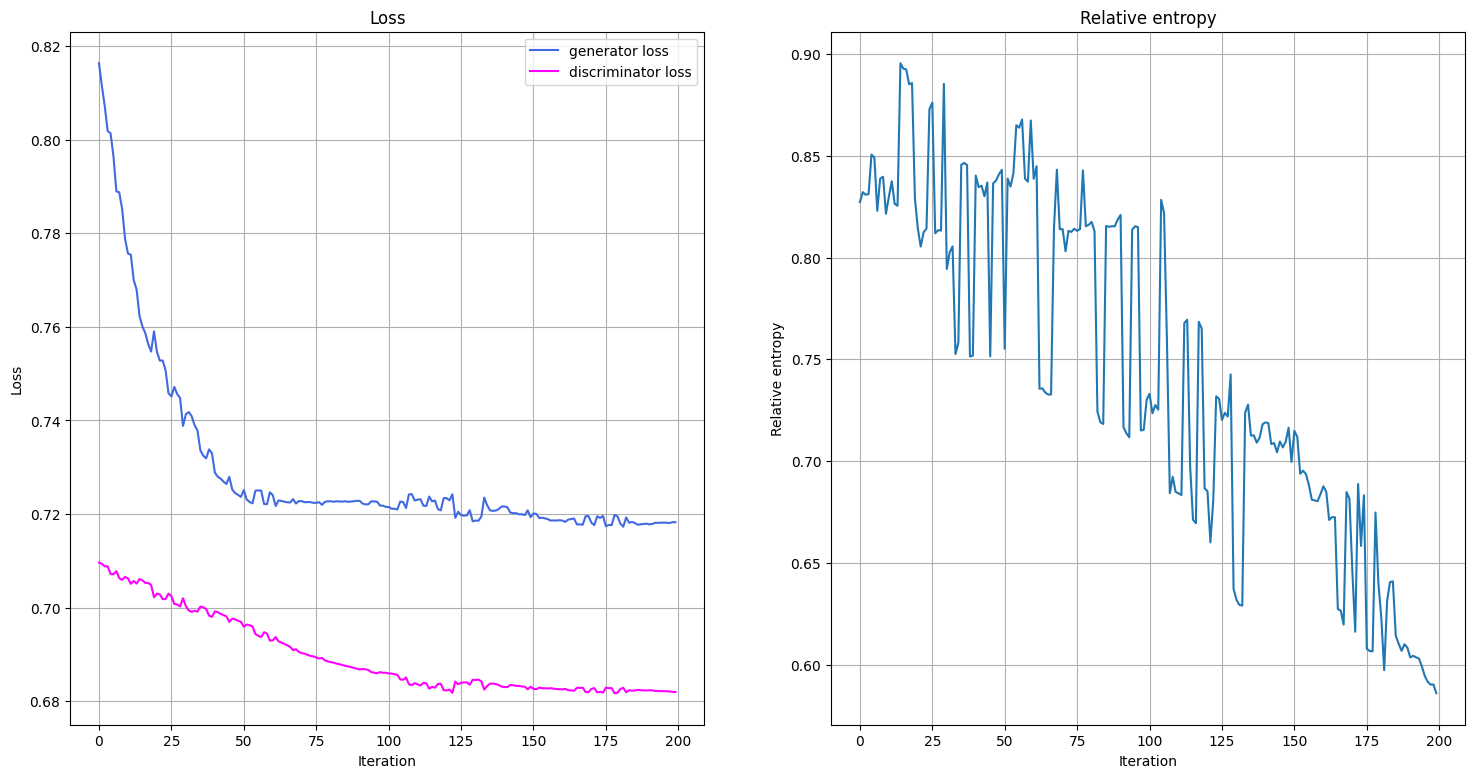

Fit in 130.52 sec


In [10]:
trainer.train(grid_elements, prob_data, num_epochs=200)

In [5]:
with torch.no_grad():
    generated_probabilities = trainer.generator().numpy()

print(generated_probabilities)

[0.001 0.004 0.012 0.017 0.002 0.011 0.041 0.022 0.01  0.012 0.003 0.01
 0.002 0.    0.009 0.005 0.    0.001 0.056 0.027 0.005 0.    0.015 0.002
 0.    0.006 0.005 0.056 0.024 0.052 0.03  0.007 0.017 0.063 0.079 0.01
 0.045 0.043 0.008 0.012 0.027 0.002 0.03  0.02  0.    0.02  0.003 0.017
 0.016 0.006 0.012 0.005 0.017 0.003 0.016 0.037 0.    0.004 0.012 0.01
 0.009 0.007 0.    0.003]


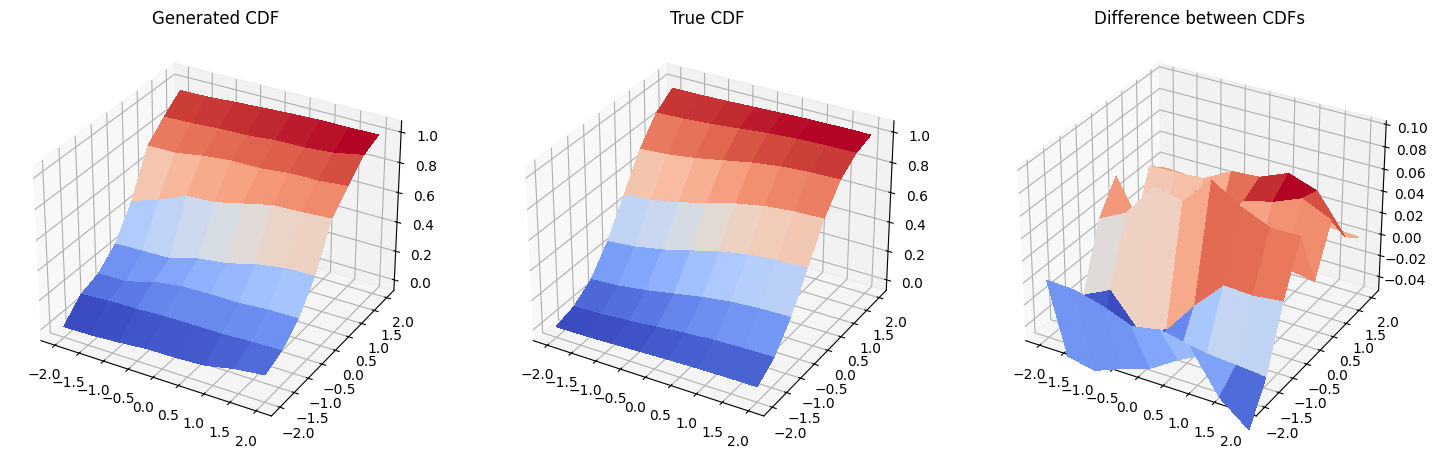

In [6]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()

In [7]:
print(type(trainer.generator.weight))

<class 'torch.nn.parameter.Parameter'>


In [8]:
parameters = list(trainer.generator.parameters())[0].detach().numpy().tolist()
print(parameters)

[0.6642323732376099, 0.4230235517024994, 0.012390057556331158, 0.9596489071846008, 0.8622044920921326, 0.42295530438423157, 0.3201139569282532, 0.6836233139038086, 0.9312663674354553, 0.7736397385597229, 0.2802864909172058, 0.5400092601776123, 0.06798318028450012, 0.5329530239105225, 0.39556846022605896, 0.38157615065574646, 0.6990246176719666, 0.25824642181396484, 0.059265244752168655, 0.20866753160953522, 0.2685653865337372, 0.5650316476821899, 0.777964174747467, 0.2567494213581085, 0.3879658579826355, 0.7963310480117798, 0.0743916854262352, 0.1213960200548172, 0.6090096831321716, 0.45126020908355713, 0.6426091194152832, 0.4232766926288605, 0.8904396891593933, 0.6972430348396301, 0.806946873664856, 0.93976229429245, 0.5971521735191345, 0.6686583161354065, 0.9748396277427673, 0.9295042157173157, 0.7432955503463745, 0.6832171082496643, 0.4213338792324066, -0.04429640620946884, 0.5587466359138489, 0.7075393795967102, 0.3469780683517456, 0.9239286184310913, 0.9073544144630432, 0.14012302

In [26]:
qc = trainer.generator_creator.circuit
theta_list = qc.parameters
print(qc.parameters)
# qc.decompose().draw()
qc.assign_parameters(dict(zip(theta_list, parameters)))
uncertainty_model = qc.assign_parameters(dict(zip(theta_list, parameters)))






ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), ParameterVectorElement(θ[26]), ParameterVectorElement(θ[27]), ParameterVectorElement(θ[28]), ParameterVectorElement(θ[29]), ParameterVectorElement(θ[30]), ParameterVectorElement(θ[31]), Par

In [27]:
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.primitives import Sampler

# backend = AerSimulator(method='statevector')
# # circ = transpile(qc, backend)
# result = backend.run(qc).result()
prob_generated = Statevector.from_instruction(uncertainty_model).data
# print(result)
# sampler = Sampler()
# result = sampler.run(uncertainty_model).result()
# results_dict = result.quasi_dists[0]
# prob_data = [results_dict[key] for key in results_dict.keys()]

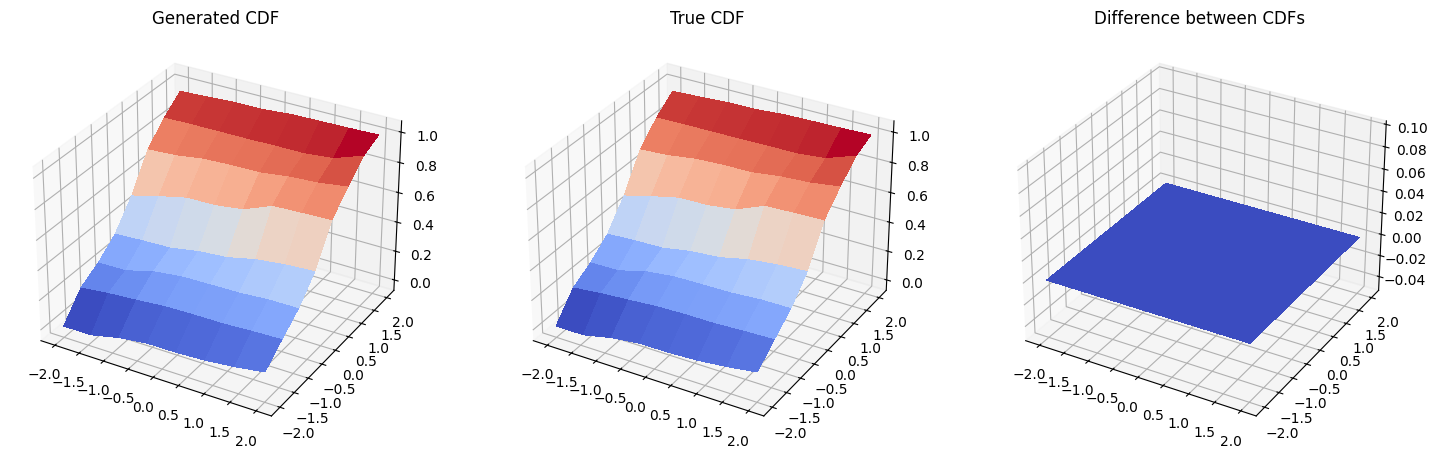

In [28]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()